In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import itertools

# Fetch historical data for a wider set of stocks
stocks = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'CRM', 'ORCL', 'IBM']
start_date = '2019-01-01'
end_date = '2024-01-01'
data = yf.download(stocks, start=start_date, end=end_date)['Close']

# Function to find the most cointegrated pair
def find_most_cointegrated_pair(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    for i, stock1 in enumerate(data.columns):
        for j, stock2 in enumerate(data.columns):
            if i < j:
                result = coint(data[stock1], data[stock2])
                pvalue_matrix[i, j] = result[1]
    min_pvalue = np.min(pvalue_matrix[np.triu_indices(n, 1)])
    if min_pvalue > 0.05:
        return None, None, None
    idx = np.argwhere(pvalue_matrix == min_pvalue)[0]
    return data.columns[idx[0]], data.columns[idx[1]], min_pvalue

stock1, stock2, pvalue = find_most_cointegrated_pair(data)

if stock1 is None:
    print("No cointegrated pair found with p-value < 0.05.")
else:
    print(f"Most cointegrated pair: {stock1} and {stock2} with p-value: {pvalue}")

S1 = data[stock1]
S2 = data[stock2]
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
beta = results.params[1]

spread = S2 - beta * S1[stock1]
spread_mean = spread.mean()
spread_std = spread.std()

# Generating signals
entry_threshold = 1.0
exit_threshold = 0.5
signals = np.where(spread > spread_mean + entry_threshold * spread_std, -1, np.nan)  # Short the spread
signals = np.where(spread < spread_mean - entry_threshold * spread_std, 1, signals)  # Long the spread
signals = np.where(abs(spread - spread_mean) < exit_threshold * spread_std, 0, signals)  # Exit


signals = pd.Series(signals, index=spread.index).ffill().fillna(0)

    # Assuming other parts of the script remain the same, including fetching data and signal generation
    
    
signalsdf = pd.DataFrame(signals, columns=['Column1'])
#signalsdf.fillna(value=np.nan, inplace=True)
signalsdf

[*********************100%%**********************]  10 of 10 completed
Most cointegrated pair: CRM and META with p-value: 0.007633649917288727


,Column1
Date,
2019-01-02,0.0
2019-01-03,0.0
2019-01-04,0.0
2019-01-07,0.0
2019-01-08,0.0
...,...
2023-12-22,0.0
2023-12-26,0.0
2023-12-27,0.0


In [4]:
# Assuming other parts of the script remain the same, including fetching data and signal generation

# Initialize a flag to track if we are in a position
in_position = False

# Adjusted backtesting loop to consider the flag
initial_capital = 10000000
capital = initial_capital
position_value = 0
daily_pnl = []

for i in range(1, len(signals)):
    if signals[i-1] != 0 and signals[i] == 0:
        # Exit condition: We are moving from a position (1 or -1) to no position (0)
        daily_return = signals[i-1] * (S2.pct_change().iloc[i] - beta * S1.drop('const', axis=1).pct_change().iloc[i])
        pnl = daily_return * position_value
        daily_pnl.append(pnl)
        capital += pnl
        position_value = 0
        in_position = False  # Update flag to indicate we are no longer in a position
    elif signals[i] != 0 and not in_position:
        # Entry condition: Signal moves from 0 to a position (1 or -1), and we are not already in a position
        position_value = capital
        in_position = True  # Update flag to indicate we are now in a position
    elif signals[i] != 0 and in_position:
        # Adjusting P&L while in position
        daily_return = signals[i] * (S2.pct_change().iloc[i] - beta * S1.drop('const', axis=1).pct_change().iloc[i])
        pnl = daily_return * position_value
        daily_pnl.append(pnl)
        capital += pnl

final_pnl = capital - initial_capital
print(f"Final P&L: {final_pnl}")


Final P&L: CRM    4.408141e+07
Name: 2019-08-09 00:00:00, dtype: float64


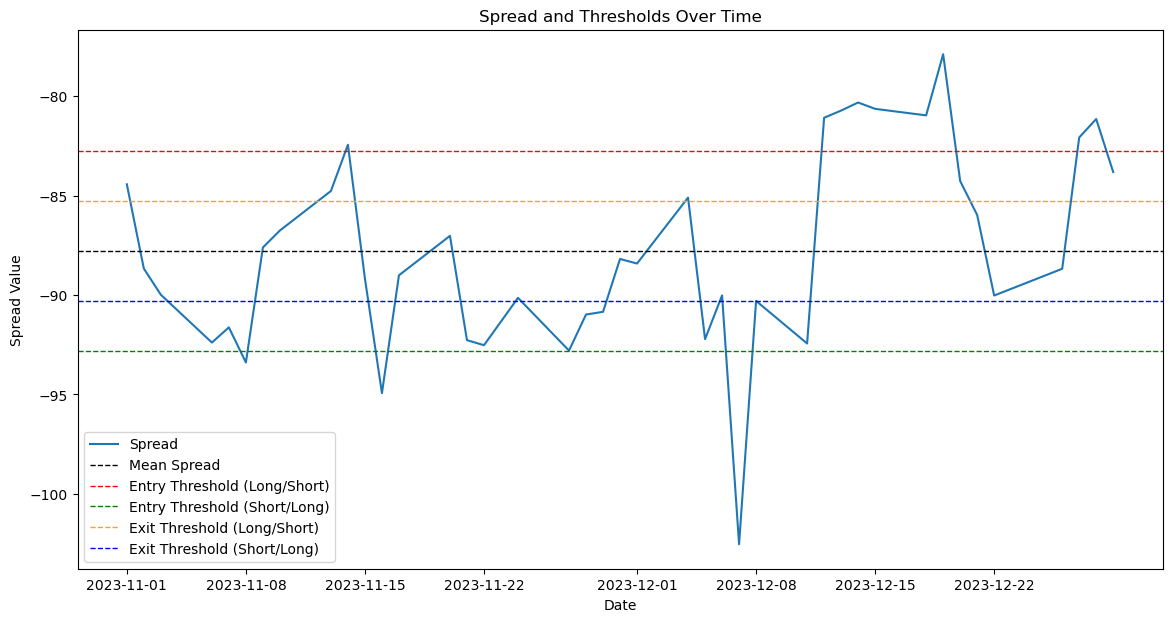

In [73]:
# Plot the spread with entry and exit thresholds
plt.figure(figsize=(14, 7))

# Plot the spread
plt.plot(spread.index, spread, label='Spread')

# Plot the mean of the spread
plt.axhline(spread_mean, color='black', linestyle='--', linewidth=1, label='Mean Spread')

# Plot entry and exit thresholds
plt.axhline(spread_mean + entry_threshold * spread_std, color='red', linestyle='--', linewidth=1, label='Entry Threshold (Long/Short)')
plt.axhline(spread_mean - entry_threshold * spread_std, color='green', linestyle='--', linewidth=1, label='Entry Threshold (Short/Long)')
plt.axhline(spread_mean + exit_threshold * spread_std, color='orange', linestyle='--', linewidth=1, label='Exit Threshold (Long/Short)')
plt.axhline(spread_mean - exit_threshold * spread_std, color='blue', linestyle='--', linewidth=1, label='Exit Threshold (Short/Long)')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.title('Spread and Thresholds Over Time')
plt.show()


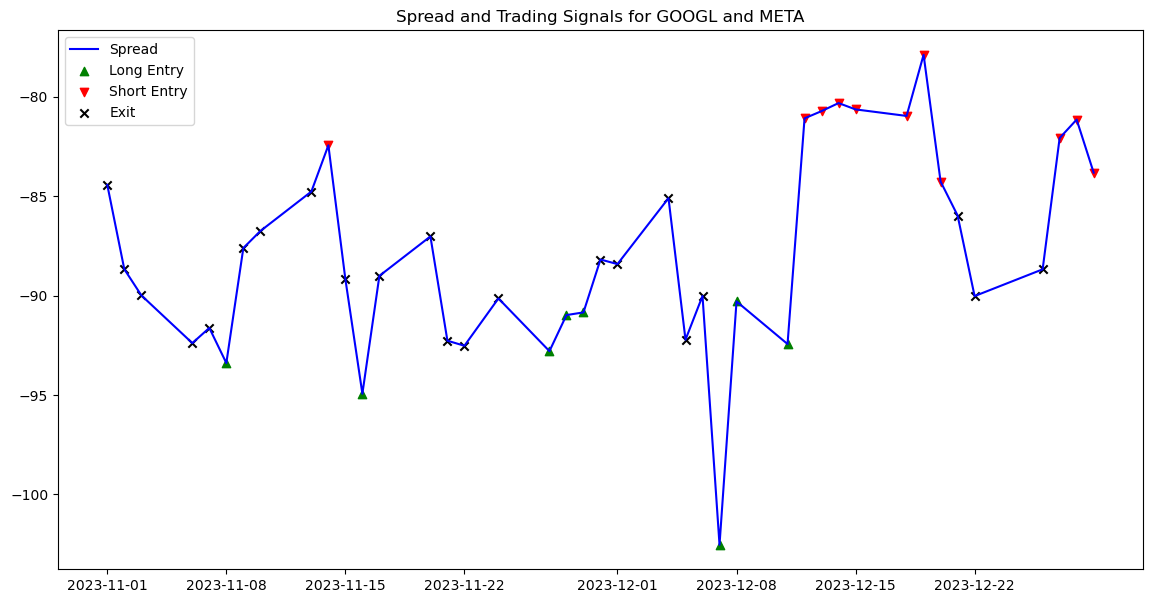

In [74]:
import matplotlib.pyplot as plt

# Plotting the spread
plt.figure(figsize=(14, 7))
plt.plot(spread.index, spread, label='Spread', color='blue')

# Highlighting the entry signals for long positions
long_entries = signals == 1
plt.scatter(spread.index[long_entries], spread[long_entries], label='Long Entry', color='green', marker='^', alpha=1)

# Highlighting the entry signals for short positions
short_entries = signals == -1
plt.scatter(spread.index[short_entries], spread[short_entries], label='Short Entry', color='red', marker='v', alpha=1)

# Highlighting the exit signals
exits = signals == 0
plt.scatter(spread.index[exits], spread[exits], label='Exit', color='black', marker='x', alpha=1)

plt.title(f'Spread and Trading Signals for {stock1} and {stock2}')
plt.legend()
plt.show()
